### InceptionV3 (previously ResNet50) Keras baseline model 

This notebook takes you through some important steps in building a deep convnet in Keras for multilabel classification of brain CT scans. 


*Update (1):*
* *training for 4 epochs instead of 3.*
* *batch size lowered to 16 from 32.*
* *training without learning rate decay.*
* *Weighted BCE instead of "plain" BCE*
* *training data lowered to 80% from 90%.*


*Update (2):*
* *adding competition metric for training*
* *using custom Callback for validation and test sets instead of the `run()` function and 'global epochs'*
* *training with "plain" BCE again*
* *merging TestDataGenerator and TrainDataGenerator into one*
* *adding undersampling (see inside `on_epoch_end`), will now run 6 epochs*

*Update (3):*
* *skipping/removing windowing (value clipping), but the transformation to Hounsfield Units is kept*
* *removing initial layer (doing np.stack((img,)&ast;3, axis=-1)) instead*
* *reducing learning rate to 5e-4 and add decay*
* *increasing batch size to 32 from 16*
* *Increasing training set to 90% of the data (10% for validation)*
* *slight increase in undersampling*
* *fixed some hardcoding for input dims/sizes*
* *training with weighted BCE again*

*Update (4):*
* *Trying out InceptionV3, instead of ResNet50*
* *undersampling without weights*
* *adding dense layers with dropout before output*
* *clipping HUs between -50 and 450 (probably the most relevant value-space?)*
* *normalization is now mapping input to 0 to 1 range, instead of -1 to 1.*
* *doing 5 epochs instead of 6*

*Update (5):*
* *Got some inspiration from [this great](https://www.kaggle.com/reppic/gradient-sigmoid-windowing) kernel by Ryan Epp*
* *Thus I'm trying out the sigmoid (brain + subdural + bone) to see if it improves the log loss*
* *Number of epochs reduced to 4, increased undersampling, and validation predictions removed due to limited time*

*Update (6) (did not improve from (5)):*
* *Going back to raw HUs (with a bit of clipping)*
* *Together with a first initial conv layer with sigmoid activation*
* *epochs increased to 6 from 4, and input size increased to (256, 256) from (224, 224)*
* *simple average of epochs (>1) for the test predictions*

*Update (7):*
* *Trying windowing based on [appian42's repo](https://github.com/appian42/kaggle-rsna-intracranial-hemorrhage/) instead*
* *I also include some cleaning based on [Jeremy's kernel](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai) (hopefully it's correct, atleast the visualization looked good =)*
* *weighted average of the epochs (>1) for the test predictions*
* *reducing number of epochs to 5*

*Update (8):*
* *Removing the extra dense layer before output layer (keeping everything else the same)*

!pip install efficientnet

In [1]:
import numpy as np
import pandas as pd
import pydicom
import cv2
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime
import sys
from sklearn.model_selection import ShuffleSplit

from math import ceil, floor, log

import pydicom

from os import listdir

from skimage.transform import resize
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split, StratifiedKFold

import tensorflow as tf
from tensorflow import keras 
import tensorflow.keras.backend as K

from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet_50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg_16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Activation, concatenate, Dropout
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model, Sequential
import tensorflow.keras.models as keras_models
from tensorflow.keras.utils import Sequence
from tensorflow.keras import utils, layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, Callback, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
#from efficientnet.tfkeras import EfficientNetB3 as efnb3

In [2]:
listdir("../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection")

['stage_2_train.csv',
 'stage_2_test',
 'stage_2_train',
 'stage_2_sample_submission.csv']

In [3]:
demo = pd.read_csv('../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv')

In [4]:
demo[:15]

,ID,Label
0,ID_0fbf6a978_epidural,0.5
1,ID_0fbf6a978_intraparenchymal,0.5
2,ID_0fbf6a978_intraventricular,0.5
3,ID_0fbf6a978_subarachnoid,0.5
4,ID_0fbf6a978_subdural,0.5
5,ID_0fbf6a978_any,0.5
6,ID_d62ec3412_epidural,0.5
7,ID_d62ec3412_intraparenchymal,0.5
8,ID_d62ec3412_intraventricular,0.5
9,ID_d62ec3412_subarachnoid,0.5


In [5]:
!cp ../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/ID_ab9bad269.dcm .

import numpy as np
import pandas as pd
import pydicom
import os
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm_notebook as tqdm
from datetime import datetime

from math import ceil, floor, log
import cv2

import tensorflow as tf
import keras

import sys

# from keras_applications.resnet import ResNet50
from keras_applications.inception_v3 import InceptionV3

from sklearn.model_selection import ShuffleSplit



In [6]:
test_images_dir = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_test/'
train_images_dir = '../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train/'

### 0. Preprocessing (brain + subudral + soft)
(REMOVED) Many thanks to [Ryan Epp](https://www.kaggle.com/reppic/gradient-sigmoid-windowing). Code is taken from his kernel (see his kernel for more information and other peoples work --- for example [David Tang](https://www.kaggle.com/dcstang/see-like-a-radiologist-with-systematic-windowing), [Marco](https://www.kaggle.com/marcovasquez/basic-eda-data-visualization), [Nanashi](https://www.kaggle.com/jesucristo/rsna-introduction-eda-models), and [Richard McKinley](https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing)). At first I thought I couldn't use sigmoid windowing for this kernel because of how expensive it is to do, but I could resize the image prior to the transformation to save a lot of computation. Not sure how much this will affect the performance of the training, but it really speeded it up.<br>
(NEW) Based on two great kernels: [appian42's repo](https://github.com/appian42/kaggle-rsna-intracranial-hemorrhage/) (windowing), [Jeremy's kernel](https://www.kaggle.com/jhoward/cleaning-the-data-for-rapid-prototyping-fastai) (cleaning)

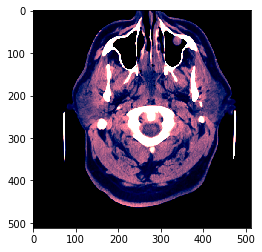

In [7]:
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    soft_img = window_image(dcm, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# Sanity Check
# Example dicoms: ID_2669954a7, ID_5c8b5d701, ID_52c9913b1

dicom = pydicom.dcmread(train_images_dir + 'ID_bfb3e4877' + '.dcm')
#                                     ID  Label
# 4045566          ID_5c8b5d701_epidural      0
# 4045567  ID_5c8b5d701_intraparenchymal      1
# 4045568  ID_5c8b5d701_intraventricular      0
# 4045569      ID_5c8b5d701_subarachnoid      1
# 4045570          ID_5c8b5d701_subdural      1
# 4045571               ID_5c8b5d701_any      1
plt.imshow(bsb_window(dicom), cmap=plt.cm.bone);


#### Check (with an example) if the correction works (visually)

def window_with_correction(dcm, window_center, window_width):
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
        correct_dcm(dcm)
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_without_correction(dcm, window_center, window_width):
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)
    return img

def window_testing(img, window):
    brain_img = window(img, 40, 80)
    subdural_img = window(img, 80, 200)
    soft_img = window(img, 40, 380)
    
    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    soft_img = (soft_img - (-150)) / 380
    bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)

    return bsb_img

# example of a "bad data point" (i.e. (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100) == True)
dicom = pydicom.dcmread(train_images_dir + "ID_bfb3e4877" + ".dcm")

fig, ax = plt.subplots(1, 2)

ax[0].imshow(window_testing(dicom, window_without_correction), cmap=plt.cm.bone);
ax[0].set_title("original")
ax[1].imshow(window_testing(dicom, window_with_correction), cmap=plt.cm.bone);
ax[1].set_title("corrected");

### 1. Helper functions

* read and transform dcms to 3-channel inputs for e.g. InceptionV3. 
* uses `bsb_window` from previous cell

\* (REMOVED) Source for windowing (although now partly removed from this kernel): https://www.kaggle.com/omission/eda-view-dicom-images-with-correct-windowing

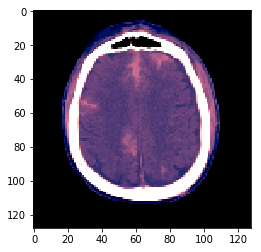

In [8]:

def _read(path, desired_size):
    """Will be used in DataGenerator"""
    
    dcm = pydicom.dcmread(path)
    
    try:
        img = bsb_window(dcm)
    except:
        img = np.zeros(desired_size)
    
    
    img = cv2.resize(img, desired_size[:2], interpolation=cv2.INTER_LINEAR)
    
    return img

# Another sanity check 
plt.imshow(
    _read(train_images_dir+'ID_5c8b5d701'+'.dcm', (128, 128)), cmap=plt.cm.bone
);

### 2. Data generators

Inherits from keras.utils.Sequence object and thus should be safe for multiprocessing.


In [9]:
class DataGenerator(Sequence):

    def __init__(self, list_IDs, labels=None, batch_size=1, img_size=(512, 512, 1), 
                 img_dir=train_images_dir, *args, **kwargs):

        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.img_dir = img_dir
        self.on_epoch_end()

    def __len__(self):
        return int(ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indices]
        
        if self.labels is not None:
            X, Y = self.__data_generation(list_IDs_temp)
            return X, Y
        else:
            X = self.__data_generation(list_IDs_temp)
            return X
        
    def on_epoch_end(self):
        
        
        if self.labels is not None: # for training phase we undersample and shuffle
            # keep probability of any=0 and any=1
            keep_prob = self.labels.iloc[:, 0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = np.arange(len(self.list_IDs))[keep]
            np.random.shuffle(self.indices)
        else:
            self.indices = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        X = np.empty((self.batch_size, *self.img_size))
        
        if self.labels is not None: # training phase
            Y = np.empty((self.batch_size, 6), dtype=np.float32)
        
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
                Y[i,] = self.labels.loc[ID].values
        
            return X, Y
        
        else: # test phase
            for i, ID in enumerate(list_IDs_temp):
                X[i,] = _read(self.img_dir+ID+".dcm", self.img_size)
            
            return X

### 3a. loss function and metric

In [10]:
def weighted_log_loss(y_true, y_pred):
    """
    Can be used as the loss function in model.compile()
    ---------------------------------------------------
    """
    
    class_weights = np.array([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    out = -(         y_true  * K.log(      y_pred) * class_weights
            + (1.0 - y_true) * K.log(1.0 - y_pred) * class_weights)
    
    return K.mean(out, axis=-1)


def _normalized_weighted_average(arr, weights=None):
    """
    A simple Keras implementation that mimics that of 
    numpy.average(), specifically for this competition
    """
    
    if weights is not None:
        scl = K.sum(weights)
        weights = K.expand_dims(weights, axis=1)
        return K.sum(K.dot(arr, weights), axis=1) / scl
    return K.mean(arr, axis=1)


def weighted_loss(y_true, y_pred):
    """
    Will be used as the metric in model.compile()
    ---------------------------------------------
    
    Similar to the custom loss function 'weighted_log_loss()' above
    but with normalized weights, which should be very similar 
    to the official competition metric:
        https://www.kaggle.com/kambarakun/lb-probe-weights-n-of-positives-scoring
    and hence:
        sklearn.metrics.log_loss with sample weights
    """
    
    class_weights = K.variable([2., 1., 1., 1., 1., 1.])
    
    eps = K.epsilon()
    
    y_pred = K.clip(y_pred, eps, 1.0-eps)

    loss = -(        y_true  * K.log(      y_pred)
            + (1.0 - y_true) * K.log(1.0 - y_pred))
    
    loss_samples = _normalized_weighted_average(loss, class_weights)
    
    return K.mean(loss_samples)


def weighted_log_loss_metric(trues, preds):
    """
    Will be used to calculate the log loss 
    of the validation set in PredictionCheckpoint()
    ------------------------------------------
    """
    class_weights = [2., 1., 1., 1., 1., 1.]
    
    epsilon = 1e-7
    
    preds = np.clip(preds, epsilon, 1-epsilon)
    loss = trues * np.log(preds) + (1 - trues) * np.log(1 - preds)
    loss_samples = np.average(loss, axis=1, weights=class_weights)

    return - loss_samples.mean()

In [11]:
SEED = 12345
np.random.seed(SEED)

TEST_SIZE = 0.01
HEIGHT = 256
WIDTH = 256
CHANNELS = 3
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
SHAPE = (HEIGHT, WIDTH, CHANNELS)

In [12]:
def read_testset(filename="../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_sample_submission.csv"):
    df = pd.read_csv(filename)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)
    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    
    return df

def read_trainset(filename="../input/rsna-intracranial-hemorrhage-detection/rsna-intracranial-hemorrhage-detection/stage_2_train.csv"):
    df = pd.read_csv(filename)
    df.drop_duplicates(subset='ID', keep=False, inplace=True)
    df["Image"] = df["ID"].str.slice(stop=12)
    df["Diagnosis"] = df["ID"].str.slice(start=13)    
    df = df.loc[:, ["Label", "Diagnosis", "Image"]]
    df = df.set_index(['Image', 'Diagnosis']).unstack(level=-1)
    df = df.sample(frac=0.1)
    
    return df

    
test_df = read_testset()
df = read_trainset()

### 3b. Model

Model is divided into three parts: <br> 

* (REMOVED) The initial layer, which will transform/map input image of shape (\_, \_, 1) to another "image" of shape (\_, \_, 3).

* The new input image is then passed through InceptionV3 (which I named "engine"). InceptionV3 could be replaced by any of the available architectures in keras_application.

* Finally, the output from InceptionV3 goes through average pooling followed by two dense layers (including output layer).

In [13]:

class PredictionCheckpoint(Callback):
    
    def __init__(self, test_df, valid_df, 
                 test_images_dir=test_images_dir, 
                 valid_images_dir=train_images_dir, 
                 batch_size=32, input_size=(256, 256, 3)):
        
        self.test_df = test_df
        self.valid_df = valid_df
        self.test_images_dir = test_images_dir
        self.valid_images_dir = valid_images_dir
        self.batch_size = batch_size
        self.input_size = input_size
        
    def on_train_begin(self, logs={}):
        self.test_predictions = []
        self.valid_predictions = []
        
    def on_epoch_end(self,batch, logs={}):
        self.test_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.test_df.index, None, self.batch_size, self.input_size, self.test_images_dir), verbose=2)[:len(self.test_df)])
        
#         Commented out to save time
        self.valid_predictions.append(
            self.model.predict_generator(
                DataGenerator(self.valid_df.index, None, self.batch_size, self.input_size, self.valid_images_dir), verbose=2)[:len(self.valid_df)])
        
        print("validation loss: %.4f" %
              weighted_log_loss_metric(self.valid_df.values, 
                                   np.average(self.valid_predictions, axis=0, 
                                              weights=[2**i for i in range(len(self.valid_predictions))])))
        
#         here you could also save the predictions with np.save()


class MyDeepModel:
    
    def __init__(self, engine, input_dims, batch_size=5, num_epochs=4, learning_rate=1e-3, 
                 decay_rate=1.0, decay_steps=1, weights="imagenet", verbose=1):
        
        self.engine = engine
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.weights = weights
        self.verbose = verbose
        self._build()

    def _build(self):
        
        
        engine = self.engine(include_top=False, weights=self.weights, input_shape=self.input_dims)
        
        x = GlobalAveragePooling2D(name='avg_pool')(engine.output)
#         x = keras.layers.Dropout(0.2)(x)
#         x = keras.layers.Dense(keras.backend.int_shape(x)[1], activation="relu", name="dense_hidden_1")(x)
#         x = keras.layers.Dropout(0.1)(x)
        out = Dense(6, activation="sigmoid", name='dense_output')(x)

        self.model = Model(inputs=engine.input, outputs=out)

        self.model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=[weighted_loss])
    

    def fit_and_predict(self, train_df, valid_df, test_df):
        
        # callbacks
        pred_history = PredictionCheckpoint(test_df, valid_df, input_size=self.input_dims)
        #checkpointer = keras.callbacks.ModelCheckpoint(filepath='%s-{epoch:02d}.hdf5' % self.engine.__name__, verbose=1, save_weights_only=True, save_best_only=False)
        scheduler = LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, floor(epoch / self.decay_steps)))
        
        self.model.fit_generator(
            DataGenerator(
                train_df.index, 
                train_df, 
                self.batch_size, 
                self.input_dims, 
                train_images_dir
            ),
            epochs=self.num_epochs,
            verbose=self.verbose,
            use_multiprocessing=True,
            workers=4,
            callbacks=[pred_history, scheduler]
        )
        
        return pred_history
    
    def save(self, path):
        self.model.save_weights(path)
    
    def load(self, path):
        self.model.load_weights(path)
        
    def save_model(self, path):
        self.model.save(path, save_format='tf')

### 4. Read csv files


### 5. Train model and predict

*Using train, validation and test set* <br>

Training for 5 epochs with Adam optimizer, with a learning rate of 0.0005 and decay rate of 0.8. The validation predictions are \[exponentially weighted\] averaged over all 5 epochs (not in this commit). `fit_and_predict` returns validation and test predictions for all epochs.


In [14]:
# train set (00%) and validation set (10%)
ss = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42).split(df.index)

# lets go for the first fold only
train_idx, valid_idx = next(ss)


# obtain model
model = MyDeepModel(engine=InceptionV3, input_dims=(256, 256, 3), batch_size=TRAIN_BATCH_SIZE, learning_rate=5e-4,
                    num_epochs=5, decay_rate=0.8, decay_steps=1, weights="imagenet", verbose=1)

# obtain test + validation predictions (history.test_predictions, history.valid_predictions)
history = model.fit_and_predict(df.iloc[train_idx], df.iloc[valid_idx], test_df)


87916544/87910968 [==============================] - 1s 0us/step
Epoch 1/5
792/793 [============================>.] - ETA: 0s - loss: 0.1595 - weighted_loss: 0.17753789/3789 - 1774s
236/236 - 126s
validation loss: 0.1301
793/793 [==============================] - 2364s 3s/step - loss: 0.1595 - weighted_loss: 0.1775
Epoch 2/5
792/793 [============================>.] - ETA: 0s - loss: 0.1291 - weighted_loss: 0.14343789/3789 - 1853s
236/236 - 121s
validation loss: 0.1145
793/793 [==============================] - 2406s 3s/step - loss: 0.1290 - weighted_loss: 0.1433
Epoch 3/5
792/793 [============================>.] - ETA: 0s - loss: 0.1126 - weighted_loss: 0.12483789/3789 - 1913s
236/236 - 125s
validation loss: 0.1092
793/793 [==============================] - 2475s 3s/step - loss: 0.1127 - weighted_loss: 0.1249
Epoch 4/5
792/793 [============================>.] - ETA: 0s - loss: 0.1015 - weighted_loss: 0.11183789/3789 - 1903s
236/236 - 124s
validation loss: 0.1035
793/793 [==============

In [15]:
export_path = "model/2"

In [16]:
model.save_model(export_path, save_format='tf')

TypeError: save_model() got an unexpected keyword argument 'save_format'

### 6. Submit test predictions

In [17]:
test_df.iloc[:, :] = np.average(history.test_predictions, axis=0, weights=[0, 1, 2, 3, 4]) # let's do a weighted average for epochs (>1)

test_df = test_df.stack().reset_index()

test_df.insert(loc=0, column='ID', value=test_df['Image'].astype(str) + "_" + test_df['Diagnosis'])

test_df = test_df.drop(["Image", "Diagnosis"], axis=1)

test_df.to_csv('submission.csv', index=False)

### 7. Improvements

Some improvements that could possibly be made:<br>
* Image augmentation (which can be put in `_read()`)
* Different learning rate and learning rate schedule
* Increased input size
* Train longer
* Add more dense layers and regularization (e.g. `keras.layers.Dropout()` before the output layer)
* Adding some optimal windowing
<br>
<br>
*Feel free to comment!*
